In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

import ast
import matplotlib.pyplot as plt
import json

2024-04-19 20:52:45.064665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 20:52:45.064850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 20:52:45.256913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Meta dataset preprocessing

In [2]:
meta_csv_file_path = '/kaggle/input/meta-pet-supplies-csv/meta_pet_supplies_csv.csv'
df_meta = pd.read_csv(meta_csv_file_path)

print("Number of rows in the dataset:", df_meta.shape[0])
print("Number of columns in the dataset:", df_meta.shape[1])

Number of rows in the dataset: 205999
Number of columns in the dataset: 19


In [3]:
df_meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"['Pet Supplies', 'Dogs', 'Health Supplies', 'H...",NaN,['Dr. Rexy hemp oil has powerful anti-inflamma...,NaN,DR.REXY Hemp Oil for Dogs and Cats - 100% Orga...,[],NaN,DR.REXY,['Made strictly with organic derived ingredien...,"['>#93,463 in Grocery &amp; Gourmet Food (See ...",[],Amazon Home,NaN,NaN,$19.90,061539972X,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
1,"['Pet Supplies', 'Dogs']",NaN,['Know exactly what your dog is eating with 10...,NaN,Pet Qwerks Treat Cookbook with Cutters,[],NaN,Pet Qwerks,"['Recipe book', 'Cookie cutters', 'Indoor/outd...","190,234 in Pet Supplies (","['B075DYQ1PH', '1604334657', '1604336919', '16...",Pet Supplies,NaN,NaN,$7.86,0615553605,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
2,"['Pet Supplies', 'Dogs', 'Food', 'Dry']",NaN,"['', '', '', '']",NaN,The Best of 101 Dog Tricks,"['0760339740', '1592533256', '1592535305', '15...",NaN,NaN,[],"76,847 in Movies &amp; TV (","['1592533256', '0760339740', '1592537308', '15...",Movies &amp; TV,NaN,NaN,NaN,0760339597,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
3,[],NaN,"['', 'The venomous but beautiful scorpionfishe...",NaN,Lionfishes and Other Scorpionfishes: The Compl...,"['1911142186', '1514291983']",NaN,Tfh/Nylabone,['Used Book in Good Condition'],"435,039 in Pet Supplies (",[],Pet Supplies,NaN,NaN,$24.99,0793816793,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
4,"['Pet Supplies', 'Top Selection from AmazonPets']",NaN,['Volume 1: 96 Words &amp; Phrases! This is th...,NaN,Pet Media Feathered Phonics The Easy Way To Te...,"['B0002FP328', 'B0002FP32S', 'B0002FP32I', 'B0...",NaN,Pet Media,['Award-winning audio CD teaches parrots how t...,"52,435 in Pet Supplies (","['B0002FP328', 'B00CAMARXG', 'B0002FP32S', 'B0...",Pet Supplies,NaN,NaN,$6.97,0972585419,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN


#### Drop duplicates

In [4]:
print('Number of products/rows in meta dataset:', df_meta.shape[0])
print('Number of unique products in meta dataset:', len(df_meta['asin'].unique()))

duplicate_rows = df_meta[df_meta.duplicated()]
print('Number of duplicated rows:', len(duplicate_rows))

df_meta = df_meta.drop_duplicates()
print('Number of products/rows in meta dataset after dropping duplicated rows:', df_meta.shape[0])

Number of products/rows in meta dataset: 205999
Number of unique products in meta dataset: 198265
Number of duplicated rows: 7734
Number of products/rows in meta dataset after dropping duplicated rows: 198265


#### Creating new column with the second category from the list of categories

In [5]:
def get_category(category_str):
    category_list = ast.literal_eval(category_str)
    if len(category_list) == 0: 
        return None
    if len(category_list) < 2:
        return category_list[0]
    return category_list[1]

df_meta['selected_category'] = df_meta['category'].apply(get_category)

In [6]:
df_meta['selected_category']

0                                  Dogs
1                                  Dogs
2                                  Dogs
3                                  None
4         Top Selection from AmazonPets
                      ...              
205994                             Dogs
205995                             Dogs
205996                             Dogs
205997                             Dogs
205998                             Dogs
Name: selected_category, Length: 198265, dtype: object

In [7]:
print('Number of unique selected categories:', df_meta['selected_category'].nunique())

Number of unique selected categories: 89


#### Some records now contain None value in the selected_category, because some of the lists in the category column are empty, we will remove them

In [8]:
print('Number of products/rows in meta dataset:', df_meta.shape[0])
none_count = df_meta['selected_category'].isna().sum()
print("Number of None values in selected_category column:", none_count)

df_meta = df_meta[df_meta['selected_category'].notna()]

print("Number of None values in selected_category column after dropping rows with None values:", df_meta['selected_category'].isna().sum())
print('Number of products/rows in meta dataset after dropping rows with None values:', df_meta.shape[0])

Number of products/rows in meta dataset: 198265
Number of None values in selected_category column: 16097
Number of None values in selected_category column after dropping rows with None values: 0
Number of products/rows in meta dataset after dropping rows with None values: 182168


#### Checking which categories we have selected

In [9]:
unique_selected_category_values = df_meta['selected_category'].unique()
print(unique_selected_category_values)

['Dogs' 'Top Selection from AmazonPets' 'Cats' 'Fish & Aquatic Pets'
 'Fish &amp; Aquatic Pets' 'Top Dog Supplies' 'Birds' 'Horses'
 'Pet Supplies' 'Small Animals' 'Pet Content - Main'
 'Try Subscribe &amp; Save' 'Pet Behavior Center' 'Bunny Rabbit Central'
 'Recurring Delivery' 'Reptiles &amp; Amphibians' 'Reptiles & Amphibians'
 'Tetra Pond' 'Try Subscribe & Save' 'Hagen' 'Top Pet Products'
 'Buy $25 Save $5 on Kaytee' 'Pet Supplies Markdowns'
 'Flea &amp; Tick Center' 'Up to 50% Off Pet Toys & Outdoor Products'
 'PetSafe' 'Flea & Tick Center' 'Cat Food &amp; Supplies' 'Aquatics Node'
 'Cat Holiday Gift Guide' 'Green'
 'Buy 1 Dog Puzzle, Save 20% on Kyjen Dog Toy' 'Pet Food'
 'Top Cat Supplies'
 'Save 20% or More on Select Aqueon & Coralife Products'
 'Pets Low Return Rate Alert'
 'Why Keep Them Waiting? | Prime Free Two-Day Shipping' 'FURminator'
 'Up to 15% Off Select Magic Coat Products' 'Pet Birthday'
 'Pets High Return Rate Alert'
 'Andis Savings: $10 Off $50 or $20 Off $100'
 '

#### Some of the selected categories have disturbed format - contain '\&amp;' instead of '&', so they are duplicated

#### For example: 
- Fish \&amp; Aquatic Pets - Fish & Aquatic Pets
- Cat Food \&amp; Supplies - Cat Food & Supplies

#### We will replace '\&amp;' with '&'

In [10]:
df_meta['selected_category'] = df_meta['selected_category'].str.replace('&amp;', '&', regex=False)
print('Number of unique selected categories after replacing &amp; with &:', len(df_meta['selected_category'].unique()))

Number of unique selected categories after replacing &amp; with &: 84


In [11]:
df_meta_selected = df_meta[['asin', 'selected_category']].copy()
df_meta_selected

,asin,selected_category
0,061539972X,Dogs
1,0615553605,Dogs
2,0760339597,Dogs
4,0972585419,Top Selection from AmazonPets
5,0975412868,Cats
...,...,...
205994,B01HJ9ULQW,Dogs
205995,B01HJ9OZZA,Dogs
205996,B01HJABKBQ,Dogs
205997,B01HJCJ8KO,Dogs


---------

In [12]:
user = "users-6"
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,APFEB2OQRCTWM,B00025K10W,B000QJETYS,B003ZYF1R0
1,A24REJO42DE368,B00025K10W,B00D5AOC2O,B00BRXP8LA
2,A3TFU7Q20D66LF,B00025K10W,B0180A1CWG,B00ZASGV78
3,A3E99CV86WDAJ9,B00025K10W,B0029NMQO4,B0002ARYWU
4,A303WJA0WDZDW6,B00025K10W,B013TKCZZK,B00K0PQII8
...,...,...,...,...
42645,AMOIPX2IFKR03,B01DQQDMKO,B01BPCLKDM,B015G31EGE
42646,A1QUYU9SVCJJFK,B01DQQDMKO,B01GJJHPLC,B01GU6YW60
42647,A1QBFOFQTTD9VV,B01GQHMRRY,B001W2NMGY,B00X4SAP82
42648,AMHN9S332K3G0,B01GQHMRRY,B0022KCNPQ,B00CKFL93K


In [13]:
parameters = {}
parameters['user'] = user

#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset

In [14]:
valid_product_ids = df_meta_selected['asin']
print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 42650
Number of sequences and targets after removal: 41969


In [15]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

### Creating an encoding dictionary, initially only from product categories in which products from targets are

In [16]:
unique_product_ids = filtered_df_users['productID'].unique()
print('Number of unique products in targets:', len(unique_product_ids))

filtered_df_for_targets = df_meta_selected[df_meta_selected['asin'].isin(unique_product_ids)].copy()
filtered_df_for_targets

Number of unique products in targets: 124


,asin,selected_category
1480,B00025K10W,Top Selection from AmazonPets
1748,B00028HN3M,Dogs
1810,B00028ZM4E,Dogs
2002,B0002ADJYM,Dogs
4920,B0002DHXX2,Cats
...,...,...
165800,B00YWPHXBI,Dogs
184305,B018S3AOLU,Dogs
189475,B01B5KJ1FS,Top Selection from AmazonPets
196150,B01DQQDMKO,Dogs


In [17]:
parameters['number_of_unique_products_in_targets'] = len(unique_product_ids)

In [18]:
unique_selected_categories_targets = filtered_df_for_targets['selected_category'].unique()
print("Product categories in which products from targets are:", unique_selected_categories_targets)

Product categories in which products from targets are: ['Top Selection from AmazonPets' 'Dogs' 'Cats' 'Pet Content - Main'
 'Horses']


In [19]:
parameters['number_of_categories_in_targets'] = len(unique_selected_categories_targets)

#### Creating an encoding dictionary

In [20]:
encoding = {}
for i, category in enumerate(unique_selected_categories_targets):
    encoding[category] = i

encoding

{'Top Selection from AmazonPets': 0,
 'Dogs': 1,
 'Cats': 2,
 'Pet Content - Main': 3,
 'Horses': 4}

#### Completing the encoding dictionary with all categories

In [21]:
unique_selected_categories_all = df_meta_selected['selected_category'].unique()
i = len(encoding)

for category in unique_selected_categories_all:
    if category not in encoding:
        encoding[category] = i
        i += 1
        
print("Number of encoded categories in encoding dictionary:", len(encoding))
encoding

Number of encoded categories in encoding dictionary: 84


{'Top Selection from AmazonPets': 0,
 'Dogs': 1,
 'Cats': 2,
 'Pet Content - Main': 3,
 'Horses': 4,
 'Fish & Aquatic Pets': 5,
 'Top Dog Supplies': 6,
 'Birds': 7,
 'Pet Supplies': 8,
 'Small Animals': 9,
 'Try Subscribe & Save': 10,
 'Pet Behavior Center': 11,
 'Bunny Rabbit Central': 12,
 'Recurring Delivery': 13,
 'Reptiles & Amphibians': 14,
 'Tetra Pond': 15,
 'Hagen': 16,
 'Top Pet Products': 17,
 'Buy $25 Save $5 on Kaytee': 18,
 'Pet Supplies Markdowns': 19,
 'Flea & Tick Center': 20,
 'Up to 50% Off Pet Toys & Outdoor Products': 21,
 'PetSafe': 22,
 'Cat Food & Supplies': 23,
 'Aquatics Node': 24,
 'Cat Holiday Gift Guide': 25,
 'Green': 26,
 'Buy 1 Dog Puzzle, Save 20% on Kyjen Dog Toy': 27,
 'Pet Food': 28,
 'Top Cat Supplies': 29,
 'Save 20% or More on Select Aqueon & Coralife Products': 30,
 'Pets Low Return Rate Alert': 31,
 'Why Keep Them Waiting? | Prime Free Two-Day Shipping': 32,
 'FURminator': 33,
 'Up to 15% Off Select Magic Coat Products': 34,
 'Pet Birthday': 35,

#### Encoding text categories to numeric values so we will have a numeric category value for each product

In [22]:
df_meta_selected_encoded = df_meta_selected.copy()
df_meta_selected_encoded['selected_category'] = df_meta_selected_encoded['selected_category'].map(encoding)

### Encoding product IDs into numeric product categories

#### First, selecting all unique product IDs from sequences and targets

In [23]:
unique_productID = filtered_df_users['productID'].unique()
unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()

merged = np.concatenate((unique_productID, unique_purchased_before_1, unique_purchased_before_2))

unique_merged = np.unique(merged)
print("Number of unique products in sequences and targets:", len(unique_merged))

Number of unique products in sequences and targets: 19503


In [24]:
parameters['number_of_unique_products_in_sequences_and_targets'] = len(unique_merged)

#### Selecting from all products which are in the meta dataset, only those which are in sequences and targets

In [25]:
filtered_df = df_meta_selected_encoded[df_meta_selected_encoded['asin'].isin(unique_merged)].copy()
filtered_df.shape[0]

19503

#### Number of unique categories in which users have purchased products / Number of categories in which are products from sequences and targets

In [26]:
unique_categories_count = filtered_df['selected_category'].nunique()
print(unique_categories_count)

46


In [27]:
parameters['number_of_categories'] = unique_categories_count

#### Creating encoding dictionary which maps product IDs into numeric product categories

In [28]:
encoding_productID_to_category = filtered_df.set_index('asin')['selected_category'].to_dict()

print("Number of encoded products:", len(encoding_productID_to_category))

Number of encoded products: 19503


### Creating encoded sequences and targets

In [29]:
filtered_df_users_encoded = filtered_df_users.copy()
filtered_df_users_encoded = filtered_df_users_encoded.drop(columns='reviewerID')

filtered_df_users_encoded['productID'] = filtered_df_users_encoded['productID'].map(encoding_productID_to_category)
filtered_df_users_encoded['purchased_before_1'] = filtered_df_users_encoded['purchased_before_1'].map(encoding_productID_to_category)
filtered_df_users_encoded['purchased_before_2'] = filtered_df_users_encoded['purchased_before_2'].map(encoding_productID_to_category)
filtered_df_users_encoded

,productID,purchased_before_1,purchased_before_2
0,0,1,1
1,0,1,1
2,0,1,6
3,0,1,1
4,0,1,1
...,...,...,...
42645,1,1,1
42646,1,1,1
42647,1,1,1
42648,1,1,2


#### Dropping duplicated sequences and targets

In [30]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users_encoded.shape[0])

filtered_df_users_encoded_unique = filtered_df_users_encoded.drop_duplicates()

print("Number of sequences and targets after dropping duplicates:", filtered_df_users_encoded_unique.shape[0])

Number of sequences and targets before dropping duplicates: 41969
Number of sequences and targets after dropping duplicates: 401


In [31]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users_encoded_unique.shape[0]

In [32]:
sequences = filtered_df_users_encoded_unique[['purchased_before_1', 'purchased_before_2']].values
targets = filtered_df_users_encoded_unique['productID'].values

sequences[:10], targets[:10]

(array([[1, 1],
        [1, 6],
        [2, 2],
        [9, 1],
        [1, 1],
        [2, 1],
        [2, 2],
        [7, 5],
        [1, 5],
        [1, 2]]),
 array([0, 0, 0, 0, 1, 0, 2, 0, 0, 0]))

In [33]:
targets_df = pd.DataFrame(targets, columns=['category'])
number_of_records_per_productID = targets_df['category'].value_counts().reset_index()
number_of_records_per_productID.columns = ['category', 'numberOfRecordsPerCategory']
number_of_records_per_productID

,category,numberOfRecordsPerCategory
0,1,202
1,2,132
2,0,44
3,4,14
4,3,9


In [34]:
total_records = number_of_records_per_productID['numberOfRecordsPerCategory'].sum()
probabilities = number_of_records_per_productID['numberOfRecordsPerCategory'] / total_records

entropy = -np.sum(probabilities * np.log2(probabilities))
final_entropy = entropy / np.log2(number_of_records_per_productID.shape[0])
parameters['data_entropy'] = round(final_entropy, 4)
parameters['mean_number_of_records_per_category'] = number_of_records_per_productID['numberOfRecordsPerCategory'].mean()

----------

In [35]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)

In [36]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique categories) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 321
Number of validation sequences: 41
Number of test sequences: 39

Number of train targets: 321
Number of validation targets: 41
Number of test targets: 39

Number of classes (unique categories) in the train targets: 5
Number of classes in the validation targets: 5
Number of classes in the test targets: 5


In [37]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_categories_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_categories_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_categories_in_targets_test'] = len(set(y_test))

----------

# Modeling

In [38]:
"""
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight=None,
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
"""

'\nfrom sklearn.utils.class_weight import compute_class_weight\n\nclass_weights = compute_class_weight(\n    class_weight=None,\n    classes=np.unique(y_train),\n    y=y_train\n)\n\nclass_weight_dict = dict(enumerate(class_weights))\n'

#### Applying logarithmic scale to moderate high weights

In [39]:
def custom_class_weights(y_train):
    class_counts = np.bincount(y_train)
    total_instances = len(y_train)
    weights = total_instances / (len(class_counts) * class_counts)
    return np.log1p(weights)

class_weight_dict = {i: weight for i, weight in enumerate(custom_class_weights(y_train))}

#### Implementation of calculation of multiclass weighted F1-score, because TensorFlow or Keras does not provide multiclass F1-score metric

In [40]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=len(unique_selected_categories_targets))
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=len(unique_selected_categories_targets))

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

## LSTM

In [41]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_lstm.add(LSTM(4, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(4, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=[f1_score]
)

In [42]:
history_model_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    verbose=0,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

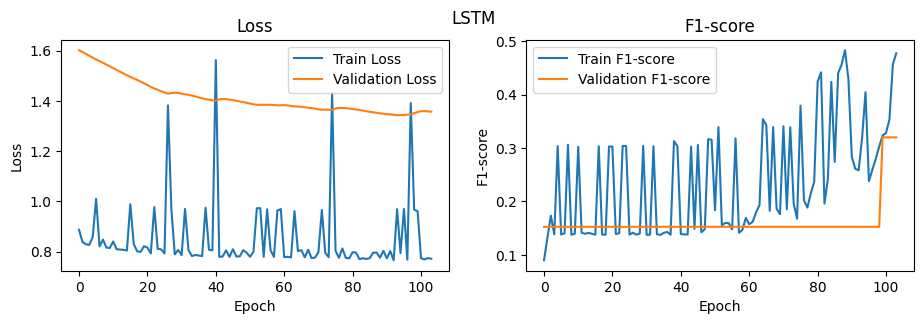

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('LSTM')
plt.show()

In [44]:
test_loss_model_lstm, test_f1_score_model_lstm = model_lstm.evaluate(X_test, y_test)

probabilities_model_lstm = model_lstm.predict(X_test)
y_pred_model_lstm = np.argmax(probabilities_model_lstm, axis=1)
report_dict_model_lstm = classification_report(y_test, y_pred_model_lstm, output_dict=True)

weighted_avg_model_lstm = report_dict_model_lstm['weighted avg']
test_weighted_avg_precision_model_lstm = round(weighted_avg_model_lstm['precision'], 4)
test_weighted_avg_recall_model_lstm = round(weighted_avg_model_lstm['recall'], 4)
test_weighted_avg_f1_model_lstm = round(weighted_avg_model_lstm['f1-score'], 4)

macro_avg_model_lstm = report_dict_model_lstm['macro avg']
test_macro_avg_precision_model_lstm = round(macro_avg_model_lstm['precision'], 4)
test_macro_avg_recall_model_lstm = round(macro_avg_model_lstm['recall'], 4)
test_macro_avg_f1_model_lstm = round(macro_avg_model_lstm['f1-score'], 4)

test_loss_model_lstm = round(test_loss_model_lstm, 4)
test_accuracy_model_lstm = round(report_dict_model_lstm['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_lstm)
print("Test weighted avg precision:", test_weighted_avg_precision_model_lstm)
print("Test weighted avg recall:", test_weighted_avg_recall_model_lstm)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_lstm)
print("Test macro avg precision:", test_macro_avg_precision_model_lstm)
print("Test macro avg recall:", test_macro_avg_recall_model_lstm)
print("-----------------------------------------")
print("Test loss:", test_loss_model_lstm)
print("Test accuracy:", test_accuracy_model_lstm)
print("-----------------------------------------")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.3205 - loss: 1.3743 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
-----------------------------------------
Test weighted avg f1-score: 0.3477
Test weighted avg precision: 0.263
Test weighted avg recall: 0.5128
-----------------------------------------
Test macro avg f1-score: 0.1356
Test macro avg precision: 0.1026
Test macro avg recall: 0.2
-----------------------------------------
Test loss: 1.4189
Test accuracy: 0.5128
-----------------------------------------


In [45]:
parameters['test_weighted_avg_f1_model_lstm'] = test_weighted_avg_f1_model_lstm
parameters['test_weighted_avg_precision_model_lstm'] = test_weighted_avg_precision_model_lstm
parameters['test_weighted_avg_recall_model_lstm'] = test_weighted_avg_recall_model_lstm

parameters['test_macro_avg_f1_model_lstm'] = test_macro_avg_f1_model_lstm
parameters['test_macro_avg_precision_model_lstm'] = test_macro_avg_precision_model_lstm
parameters['test_macro_avg_recall_model_lstm'] = test_macro_avg_recall_model_lstm

parameters['test_loss_model_lstm'] = test_loss_model_lstm
parameters['test_accuracy_model_lstm'] = test_accuracy_model_lstm

---------

# Bidirectional-LSTM

In [84]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_bi_lstm.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(8, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[f1_score]
)

In [85]:
history_model_bi_lstm = model_bi_lstm.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    verbose=0,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

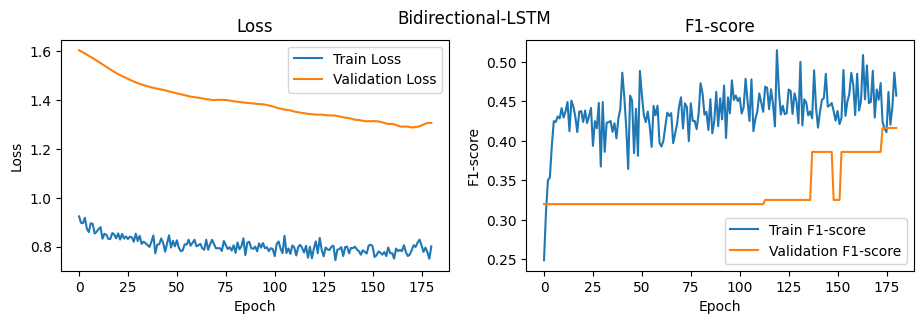

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [87]:
test_loss_model_bi_lstm, test_f1_score_model_bi_lstm = model_bi_lstm.evaluate(X_test, y_test)

probabilities_model_bi_lstm = model_bi_lstm.predict(X_test)
y_pred_model_bi_lstm = np.argmax(probabilities_model_bi_lstm, axis=1)
report_dict_model_bi_lstm = classification_report(y_test, y_pred_model_bi_lstm, output_dict=True)

weighted_avg_model_bi_lstm = report_dict_model_bi_lstm['weighted avg']
test_weighted_avg_precision_model_bi_lstm = round(weighted_avg_model_bi_lstm['precision'], 4)
test_weighted_avg_recall_model_bi_lstm = round(weighted_avg_model_bi_lstm['recall'], 4)
test_weighted_avg_f1_model_bi_lstm = round(weighted_avg_model_bi_lstm['f1-score'], 4)

macro_avg_model_bi_lstm = report_dict_model_bi_lstm['macro avg']
test_macro_avg_precision_model_bi_lstm = round(macro_avg_model_bi_lstm['precision'], 4)
test_macro_avg_recall_model_bi_lstm = round(macro_avg_model_bi_lstm['recall'], 4)
test_macro_avg_f1_model_bi_lstm = round(macro_avg_model_bi_lstm['f1-score'], 4)

test_loss_model_bi_lstm = round(test_loss_model_bi_lstm, 4)
test_accuracy_model_bi_lstm = round(report_dict_model_bi_lstm['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_bi_lstm)
print("Test weighted avg precision:", test_weighted_avg_precision_model_bi_lstm)
print("Test weighted avg recall:", test_weighted_avg_recall_model_bi_lstm)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_bi_lstm)
print("Test macro avg precision:", test_macro_avg_precision_model_bi_lstm)
print("Test macro avg recall:", test_macro_avg_recall_model_bi_lstm)
print("-----------------------------------------")
print("Test loss:", test_loss_model_bi_lstm)
print("Test accuracy:", test_accuracy_model_bi_lstm)
print("-----------------------------------------")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.3899 - loss: 1.3109 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
-----------------------------------------
Test weighted avg f1-score: 0.38
Test weighted avg precision: 0.3476
Test weighted avg recall: 0.4359
-----------------------------------------
Test macro avg f1-score: 0.1665
Test macro avg precision: 0.1566
Test macro avg recall: 0.1862
-----------------------------------------
Test loss: 1.3586
Test accuracy: 0.4359
-----------------------------------------


In [88]:
parameters['test_weighted_avg_f1_model_bi_lstm'] = test_weighted_avg_f1_model_bi_lstm
parameters['test_weighted_avg_precision_model_bi_lstm'] = test_weighted_avg_precision_model_bi_lstm
parameters['test_weighted_avg_recall_model_bi_lstm'] = test_weighted_avg_recall_model_bi_lstm

parameters['test_macro_avg_f1_model_bi_lstm'] = test_macro_avg_f1_model_bi_lstm
parameters['test_macro_avg_precision_model_bi_lstm'] = test_macro_avg_precision_model_bi_lstm
parameters['test_macro_avg_recall_model_bi_lstm'] = test_macro_avg_recall_model_bi_lstm

parameters['test_loss_model_bi_lstm'] = test_loss_model_bi_lstm
parameters['test_accuracy_model_bi_lstm'] = test_accuracy_model_bi_lstm

----------

# GRU

In [51]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_gru.add(GRU(16, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[f1_score]
)

In [52]:
history_model_gru = model_gru.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    verbose=0,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

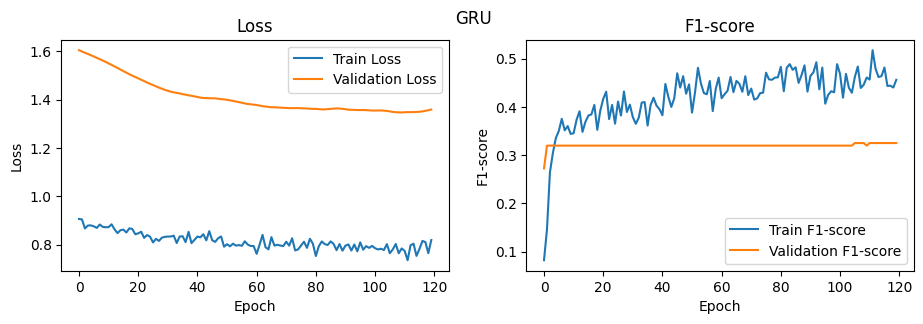

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('GRU')
plt.show()

In [54]:
test_loss_model_gru, test_f1_score_model_gru = model_gru.evaluate(X_test, y_test)

probabilities_model_gru = model_gru.predict(X_test)
y_pred_model_gru = np.argmax(probabilities_model_gru, axis=1)
report_dict_model_gru = classification_report(y_test, y_pred_model_gru, output_dict=True)

weighted_avg_model_gru = report_dict_model_gru['weighted avg']
test_weighted_avg_precision_model_gru = round(weighted_avg_model_gru['precision'], 4)
test_weighted_avg_recall_model_gru = round(weighted_avg_model_gru['recall'], 4)
test_weighted_avg_f1_model_gru = round(weighted_avg_model_gru['f1-score'], 4)

macro_avg_model_gru = report_dict_model_gru['macro avg']
test_macro_avg_precision_model_gru = round(macro_avg_model_gru['precision'], 4)
test_macro_avg_recall_model_gru = round(macro_avg_model_gru['recall'], 4)
test_macro_avg_f1_model_gru = round(macro_avg_model_gru['f1-score'], 4)

test_loss_model_gru = round(test_loss_model_gru, 4)
test_accuracy_model_gru = round(report_dict_model_gru['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_gru)
print("Test weighted avg precision:", test_weighted_avg_precision_model_gru)
print("Test weighted avg recall:", test_weighted_avg_recall_model_gru)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_gru)
print("Test macro avg precision:", test_macro_avg_precision_model_gru)
print("Test macro avg recall:", test_macro_avg_recall_model_gru)
print("-----------------------------------------")
print("Test loss:", test_loss_model_gru)
print("Test accuracy:", test_accuracy_model_gru)
print("-----------------------------------------")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.3960 - loss: 1.3338 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
-----------------------------------------
Test weighted avg f1-score: 0.3897
Test weighted avg precision: 0.3818
Test weighted avg recall: 0.5128
-----------------------------------------
Test macro avg f1-score: 0.1607
Test macro avg precision: 0.1722
Test macro avg recall: 0.2054
-----------------------------------------
Test loss: 1.3685
Test accuracy: 0.5128
-----------------------------------------


In [55]:
parameters['test_weighted_avg_f1_model_gru'] = test_weighted_avg_f1_model_gru
parameters['test_weighted_avg_precision_model_gru'] = test_weighted_avg_precision_model_gru
parameters['test_weighted_avg_recall_model_gru'] = test_weighted_avg_recall_model_gru

parameters['test_macro_avg_f1_model_gru'] = test_macro_avg_f1_model_gru
parameters['test_macro_avg_precision_model_gru'] = test_macro_avg_precision_model_gru
parameters['test_macro_avg_recall_model_gru'] = test_macro_avg_recall_model_gru

parameters['test_loss_model_gru'] = test_loss_model_gru
parameters['test_accuracy_model_gru'] = test_accuracy_model_gru

--------

# AED Autoencoder

In [56]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=len(unique_selected_categories_targets), output_dim=10))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(len(unique_selected_categories_targets), activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[f1_score]
)

In [57]:
history_model_autoencoder = model_autoencoder.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    verbose=0,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

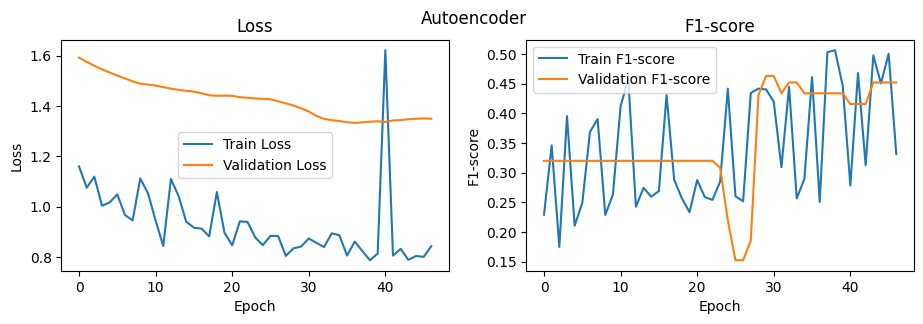

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

plt.suptitle('Autoencoder')
plt.show()

In [59]:
test_loss_model_autoencoder, test_f1_score_model_autoencoder = model_autoencoder.evaluate(X_test, y_test)

probabilities_model_autoencoder = model_autoencoder.predict(X_test)
y_pred_model_autoencoder = np.argmax(probabilities_model_autoencoder, axis=1)
report_dict_model_autoencoder = classification_report(y_test, y_pred_model_autoencoder, output_dict=True)

weighted_avg_model_autoencoder = report_dict_model_autoencoder['weighted avg']
test_weighted_avg_precision_model_autoencoder = round(weighted_avg_model_autoencoder['precision'], 4)
test_weighted_avg_recall_model_autoencoder = round(weighted_avg_model_autoencoder['recall'], 4)
test_weighted_avg_f1_model_autoencoder = round(weighted_avg_model_autoencoder['f1-score'], 4)

macro_avg_model_autoencoder = report_dict_model_autoencoder['macro avg']
test_macro_avg_precision_model_autoencoder = round(macro_avg_model_autoencoder['precision'], 4)
test_macro_avg_recall_model_autoencoder = round(macro_avg_model_autoencoder['recall'], 4)
test_macro_avg_f1_model_autoencoder = round(macro_avg_model_autoencoder['f1-score'], 4)

test_loss_model_autoencoder = round(test_loss_model_autoencoder, 4)
test_accuracy_model_autoencoder = round(report_dict_model_autoencoder['accuracy'], 4)

print("-----------------------------------------")
print("Test weighted avg f1-score:", test_weighted_avg_f1_model_autoencoder)
print("Test weighted avg precision:", test_weighted_avg_precision_model_autoencoder)
print("Test weighted avg recall:", test_weighted_avg_recall_model_autoencoder)
print("-----------------------------------------")
print("Test macro avg f1-score:", test_macro_avg_f1_model_autoencoder)
print("Test macro avg precision:", test_macro_avg_precision_model_autoencoder)
print("Test macro avg recall:", test_macro_avg_recall_model_autoencoder)
print("-----------------------------------------")
print("Test loss:", test_loss_model_autoencoder)
print("Test accuracy:", test_accuracy_model_autoencoder)
print("-----------------------------------------")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.4232 - loss: 1.3874 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
-----------------------------------------
Test weighted avg f1-score: 0.4466
Test weighted avg precision: 0.4023
Test weighted avg recall: 0.5128
-----------------------------------------
Test macro avg f1-score: 0.1917
Test macro avg precision: 0.176
Test macro avg recall: 0.2162
-----------------------------------------
Test loss: 1.4426
Test accuracy: 0.5128
-----------------------------------------


In [60]:
parameters['test_weighted_avg_f1_model_autoencoder'] = test_weighted_avg_f1_model_autoencoder
parameters['test_weighted_avg_precision_model_autoencoder'] = test_weighted_avg_precision_model_autoencoder
parameters['test_weighted_avg_recall_model_autoencoder'] = test_weighted_avg_recall_model_autoencoder

parameters['test_macro_avg_f1_model_autoencoder'] = test_macro_avg_f1_model_autoencoder
parameters['test_macro_avg_precision_model_autoencoder'] = test_macro_avg_precision_model_autoencoder
parameters['test_macro_avg_recall_model_autoencoder'] = test_macro_avg_recall_model_autoencoder

parameters['test_loss_model_autoencoder'] = test_loss_model_autoencoder
parameters['test_accuracy_model_autoencoder'] = test_accuracy_model_autoencoder

In [89]:
parameters

{'user': 'users-6',
 'number_of_sequences_and_targets_before_removal': 42650,
 'number_of_sequences_and_targets_after_removal': 41969,
 'number_of_unique_products_in_targets': 124,
 'number_of_categories_in_targets': 5,
 'number_of_unique_products_in_sequences_and_targets': 19503,
 'number_of_categories': 46,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 401,
 'data_entropy': 0.7183,
 'mean_number_of_records_per_category': 80.2,
 'number_of_sequences_and_targets_train': 321,
 'number_of_sequences_and_targets_validation': 41,
 'number_of_sequences_and_targets_test': 39,
 'number_of_unique_categories_in_targets_train': 5,
 'number_of_unique_categories_in_targets_validation': 5,
 'number_of_unique_categories_in_targets_test': 5,
 'test_weighted_avg_f1_model_lstm': 0.3477,
 'test_weighted_avg_precision_model_lstm': 0.263,
 'test_weighted_avg_recall_model_lstm': 0.5128,
 'test_macro_avg_f1_model_lstm': 0.1356,
 'test_macro_avg_precision_model_lstm': 0.1026,
 '